In [ ]:
# ! pip install imblearn

In [3]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import time


In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [5]:
# Dataset Path
# dataset_path = pathlib.Path("../previous project/flowers")
dataset_path = pathlib.Path("flowers")

# Classes is a list with the names of the Dataset folders (which are the classes)
classes = os.listdir(dataset_path)

In [6]:
data = []
images_list = []
labels_list = []

In [7]:
# Loop through the folders of the main dataset
for folder in classes:
    folder_path = dataset_path / folder
    for image in sorted(os.listdir(folder_path)):
        image_path = folder_path / image
        data.append((image_path, image, folder, classes.index(folder)))

# Create DataFrame with the data from the list data
df = pd.DataFrame(data, columns=['image_path', 'image_name', 'label_name', 'label_number'])
pd.set_option("display.max.columns", None)

In [8]:
# Show the head of the DataFrame df
df.head(10)

,image_path,image_name,label_name,label_number
0,flowers\daisy\100080576_f52e8ee070_n.jpg,100080576_f52e8ee070_n.jpg,daisy,0
1,flowers\daisy\10140303196_b88d3d6cec.jpg,10140303196_b88d3d6cec.jpg,daisy,0
2,flowers\daisy\10172379554_b296050f82_n.jpg,10172379554_b296050f82_n.jpg,daisy,0
3,flowers\daisy\10172567486_2748826a8b.jpg,10172567486_2748826a8b.jpg,daisy,0
4,flowers\daisy\10172636503_21bededa75_n.jpg,10172636503_21bededa75_n.jpg,daisy,0
5,flowers\daisy\102841525_bd6628ae3c.jpg,102841525_bd6628ae3c.jpg,daisy,0
6,flowers\daisy\10300722094_28fa978807_n.jpg,10300722094_28fa978807_n.jpg,daisy,0
7,flowers\daisy\1031799732_e7f4008c03.jpg,1031799732_e7f4008c03.jpg,daisy,0
8,flowers\daisy\10391248763_1d16681106_n.jpg,10391248763_1d16681106_n.jpg,daisy,0
9,flowers\daisy\10437754174_22ec990b77_m.jpg,10437754174_22ec990b77_m.jpg,daisy,0


In [9]:
# Count the number of images in each class of the df
image_counts = df['label_name'].value_counts()

# Calculate mean, variance, and standard deviation
mean_count = np.mean(image_counts)
variance = np.var(image_counts, ddof=0)
std_deviation = np.sqrt(variance)

print(f"Mean:", mean_count)
print(f"Variance:", variance)
print(f"Standard Deviation:", std_deviation)

Mean: 863.4
Variance: 16660.64
Standard Deviation: 129.07610158352318


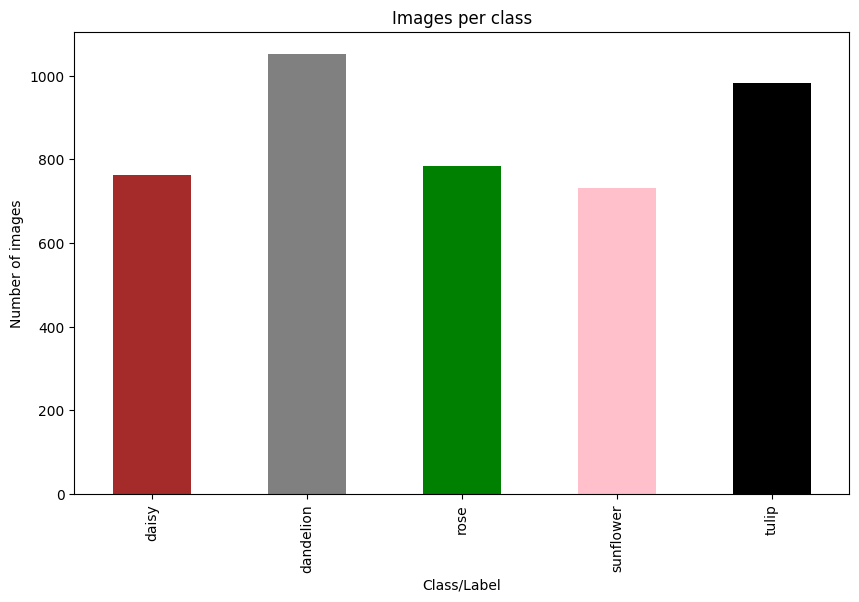

In [10]:
# Counts the occurrences of each unique value in the label_name column of the DataFrame
classes_toshow = df.label_name.value_counts().sort_index()
# Plot the classes and the number of images in each class
plt.figure(figsize = (10, 6))
classes_toshow.plot(kind='bar', color= ['brown', 'gray','green','pink','black'])

plt.title('Images per class')
plt.xlabel('Class/Label')
plt.ylabel('Number of images')
plt.show()

In [11]:
def plot_together(image_paths, title, image_num=15):
    # If the input image number is bigger than the dataset then the function stops
    if image_num > len(image_paths):
        print("Image number is bigger than the dataset!")
        return
    
    # Creates a 3x5 grid of subplots
    fig, axes = plt.subplots(3, 5, figsize=(15, 8))
    axes = axes.flatten()
    
    # For i=0 until i=image_number
    for i in range(image_num):
        # Take the image path
        img_path = image_paths[i]
        # Take the image using PIL
        img = Image.open(img_path)
        # Make subplot of the current image
        axes[i].imshow(img)
        axes[i].set_title(f"{title} {i+1}")
        axes[i].axis('off')
    
    # Show the whole plot with the subplots
    plt.show()

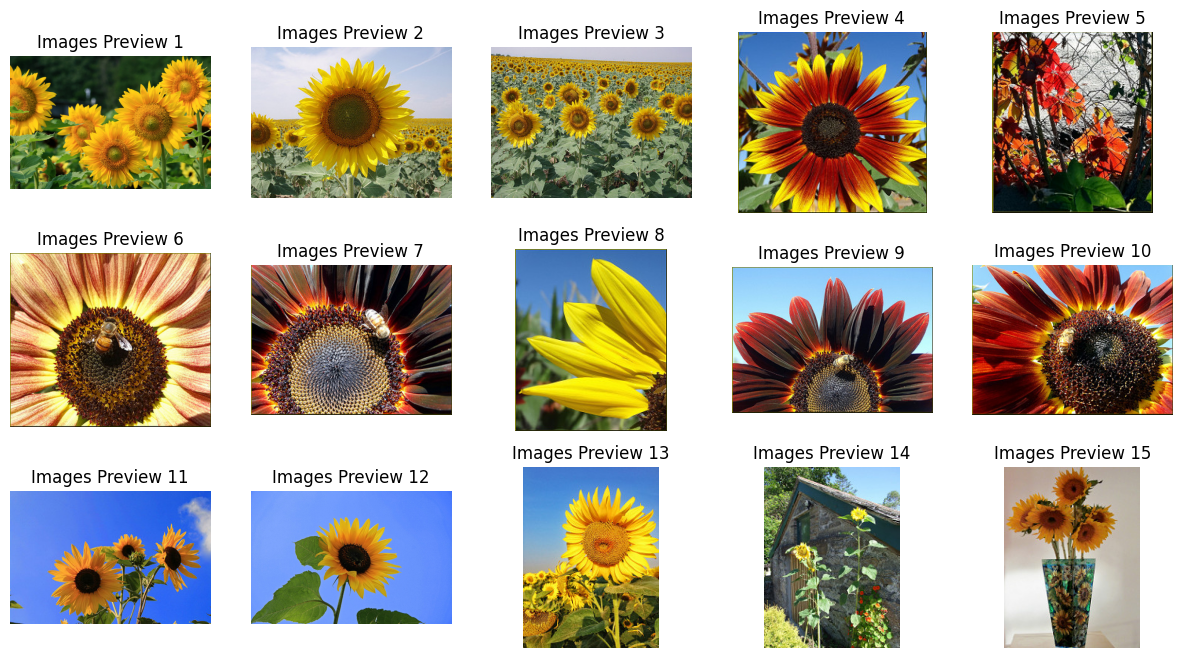

In [12]:
# Locate images with label 3 from the DataFrame
images_to_preview = df.loc[df['label_number']==3]['image_path'].values
# Call the function with our custom inputs
plot_together(images_to_preview, 'Images Preview')

In [13]:
#Encode the labels to numerical format
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label_name'])

In [14]:
# Extract image paths and labels
image_paths = df['image_path'].values
labels = df['encoded_label'].values

In [15]:
#Preprocess images (resize, flatten, normalize)
def preprocess_images(image_paths, target_size=(128, 128)):
    images = []
    for path in image_paths:
        img = Image.open(path).resize(target_size)
        img = np.array(img) / 255.0  # Normalize to [0, 1]
        images.append(img.flatten())  # Flatten the image
    return np.array(images)

X = preprocess_images(image_paths)
y = labels

In [16]:
#Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [17]:
#Shuffle the dataset after resampling
X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=42)

In [26]:
#Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

In [19]:
#Display class distribution after SMOTE
class_counts_after_smote = Counter(y_resampled)
print("Class distribution after SMOTE:", class_counts_after_smote)

Class distribution after SMOTE: Counter({2: 1052, 4: 1052, 0: 1052, 3: 1052, 1: 1052})


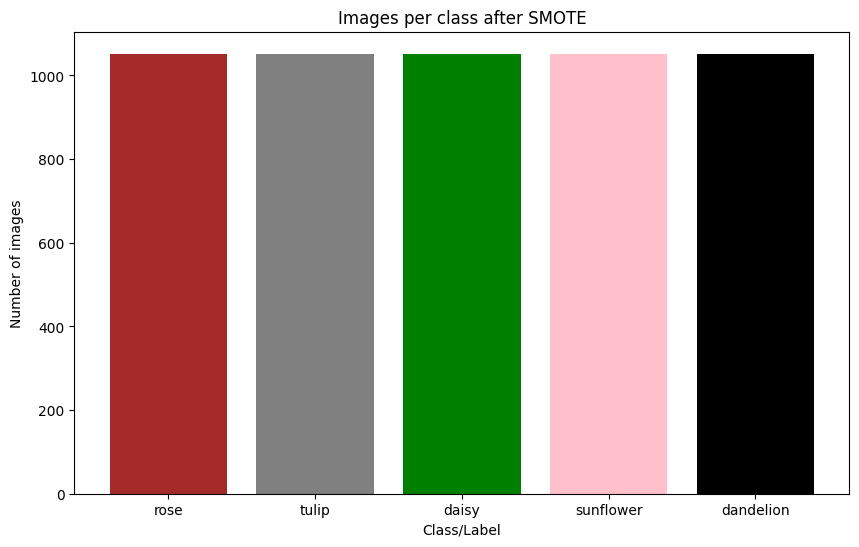

In [20]:
# Plot the classes and the number of images in each class after SMOTE
labels_after_smote = [label_encoder.inverse_transform([key])[0] for key in class_counts_after_smote.keys()]
counts_after_smote = [class_counts_after_smote[key] for key in class_counts_after_smote.keys()]

plt.figure(figsize=(10, 6))
plt.bar(labels_after_smote, counts_after_smote, color=['brown', 'gray', 'green', 'pink', 'black'])
plt.title('Images per class after SMOTE')
plt.xlabel('Class/Label')
plt.ylabel('Number of images')
plt.show()

In [21]:
#Save the training and testing data for model usage
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 4208
Testing set size: 1052


## Neural Network

In [22]:
# Reshape X_train and X_test to their original image dimensions
X_train = X_train.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 128, 128, 3)

In [ ]:
# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

In [22]:
# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [23]:
# Create the model
input_shape = (128, 128, 3)
num_classes = len(classes)
model = create_cnn_model(input_shape, num_classes)


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 307ms/step - accuracy: 0.9773 - loss: 0.0683 - val_accuracy: 0.7684 - val_loss: 1.6495
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 50s 474ms/step - accuracy: 0.9840 - loss: 0.0538 - val_accuracy: 0.7387 - val_loss: 1.6072
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 325ms/step - accuracy: 0.9686 - loss: 0.0778 - val_accuracy: 0.7637 - val_loss: 1.5326
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 38s 357ms/step - accuracy: 0.9775 - loss: 0.0604 - val_accuracy: 0.7542 - val_loss: 1.7014
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 346ms/step - accuracy: 0.9833 - loss: 0.0581 - val_accuracy: 0.7613 - val_loss: 1.7744
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 335ms/step - accuracy: 0.9767 - loss: 0.0562 - val_accuracy: 0.7423 - val_loss: 1.7247
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 32s 300ms/step - accuracy: 0.9773 - loss: 0.0566 - val_accuracy: 0.7304 - val_loss: 1.9357
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 30s 282ms/step - accuracy: 0.9792 -

In [32]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7510


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


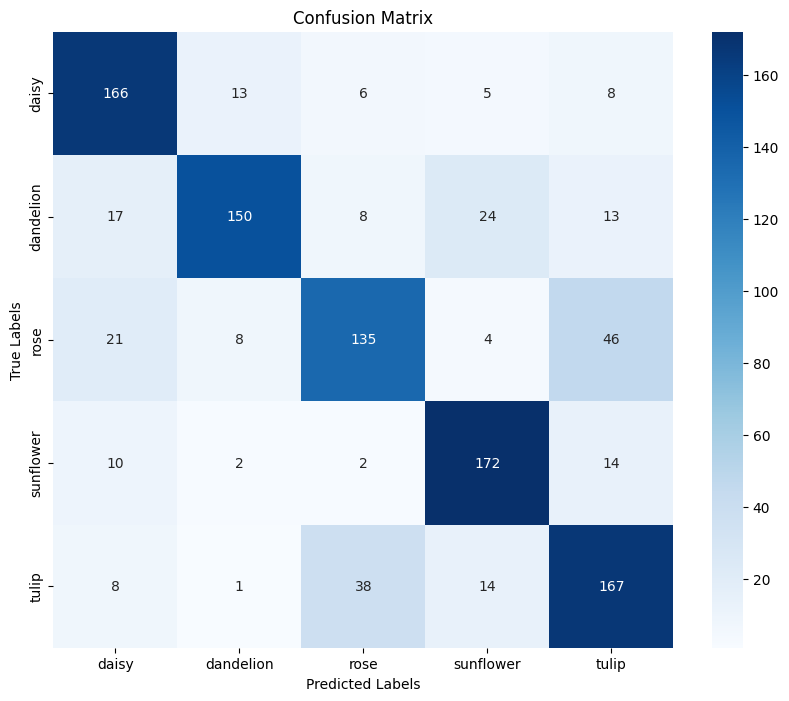

In [33]:
# Predict classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

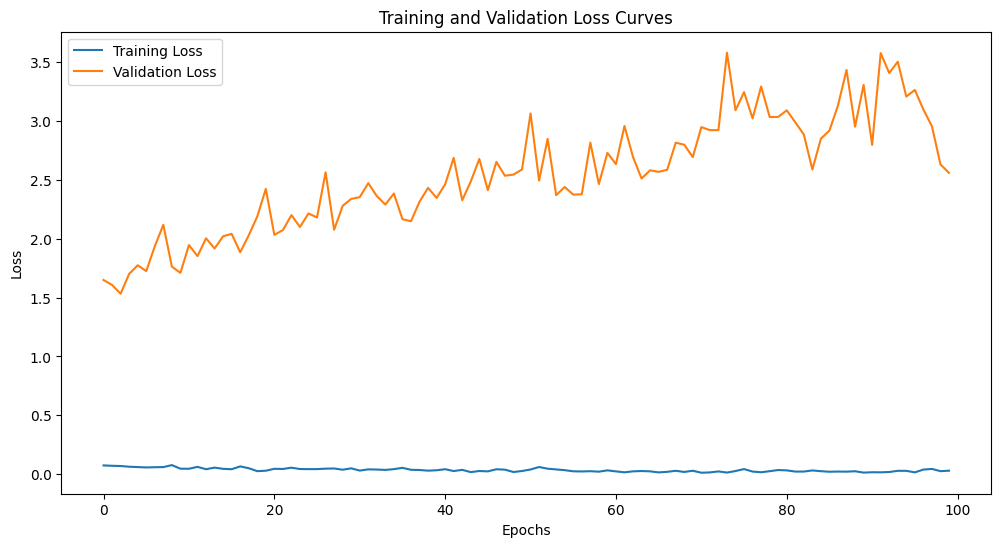

In [34]:
# Plot training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# Measure inference time for a single image
start_time = time.time()
_ = model.predict(X_test[0:1])  # Predict on a single image
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference Time for a Single Image: {inference_time:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Inference Time for a Single Image: 0.0997 seconds


## Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, learning_curve
# SVM requires 2D input (n_samples, n_features)

In [ ]:
# Train baseline SVM (initial exploration)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)



In [ ]:
# Evaluate model
y_pred = svm_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

In [ ]:
# Hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1, 1]
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Score", color="blue")
plt.plot(train_sizes, test_scores_mean, label="Validation Score", color="orange")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=range(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

## Best Model Selection (for webapp)

import joblib
// joblib.dump( // model here, 'best_model.pkl')